##  Time-Series prediction주식 예측

시계열(Time-Series) 데이터 중에서 주식 정보 데이터를 예측해 봅시다.
- 삼성 전자 주식의 시세 예측을 해봅시다. 


### 모듈 import

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## 시계열 데이터 준비
---

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume 

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)



In [22]:
# Time Series 생성

data_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(data_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

시계열 데이터가 준비되었으므로 matplotlib.pylab의 rcParams를 통해 안정성(Stationarity) 여부를 확인해 보겠습니다.

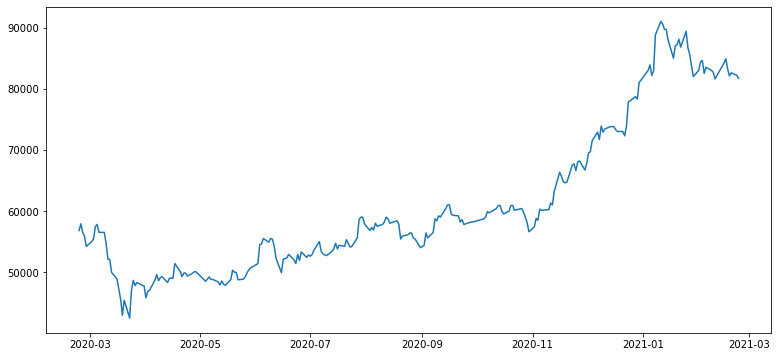

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다.
plt.plot(ts)

데이터가 안정적이지 못하네요.  
데이터 가공을 통해서 안정적인 시계열 데이터로 만들어 봅시다.

## 전처리 수행
---
- 결측치 처리
- 로그 변환

Series([], Name: Close, dtype: float64)


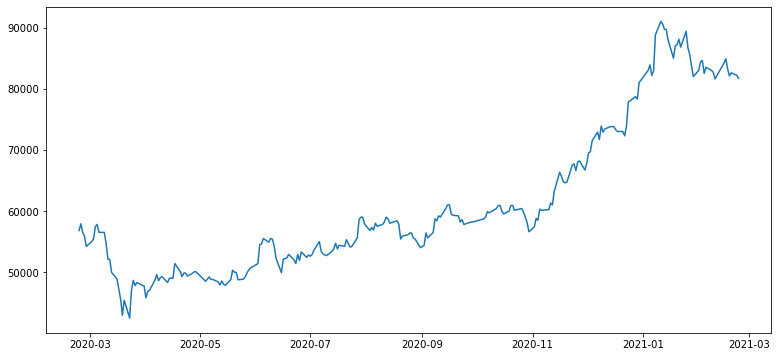

In [24]:
# 결측치 처리

# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 

ts = ts.interpolate(method='time')

print(ts[ts.isna()]) # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

plt.plot(ts)

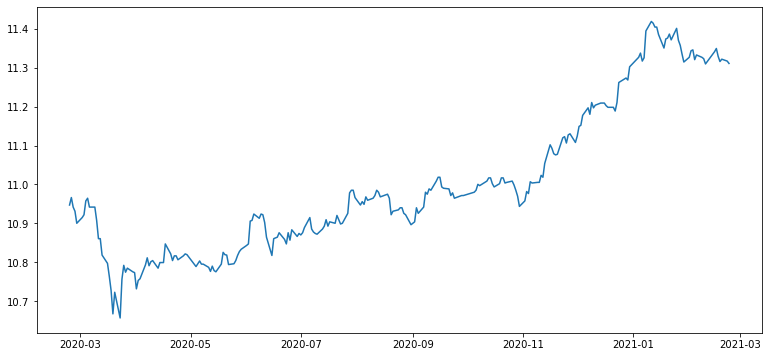

In [25]:
# 로그 변환

ts_log = np.log(ts)
plt.plot(ts_log)

## 시계열 안정성 분석
---

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 정성적 그래프 분석 ( plot_rolling_statistics )

아래의 **일정 시간 내 구간 통계치(Rolling Statistics)**를 시각화해 보는 함수입니다. 현재 타임스텝부터 `window`에 주어진 타임스텝 이전 사이 **구간의 평균(rolling mean, 이동평균)**과 **표준편차(rolling std, 이동표준편차)**를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것입니다.

In [26]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

windoe값을 12로 줘서 시각화 해보겠습니다.

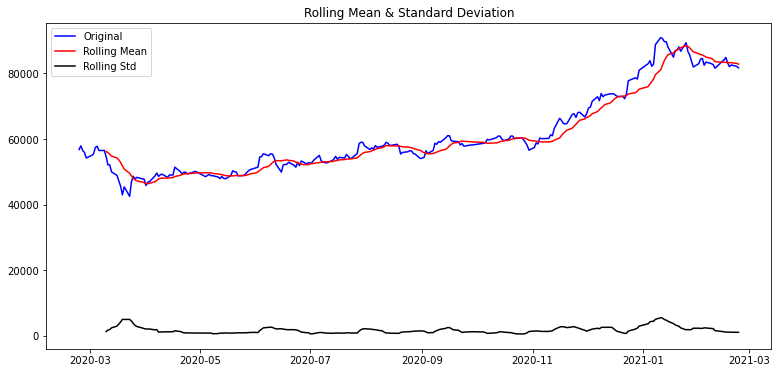

In [27]:
plot_rolling_statistics(ts, window=12)

### 정량적 Augmented Dicky-Fuller Test  (augmented_dickey_fuller_test)


 **주어진 시계열 데이터가 안정적이지 않다**라는 **귀무가설(Null Hypothesis)**를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 **이 시계열 데이터가 안정적이다**라는 **대립가설(Alternative Hypothesis)**을 채택한다는 내용입니다.

- 시계열 데이터의 안정성을 테스트하는 통계적 방법

In [28]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

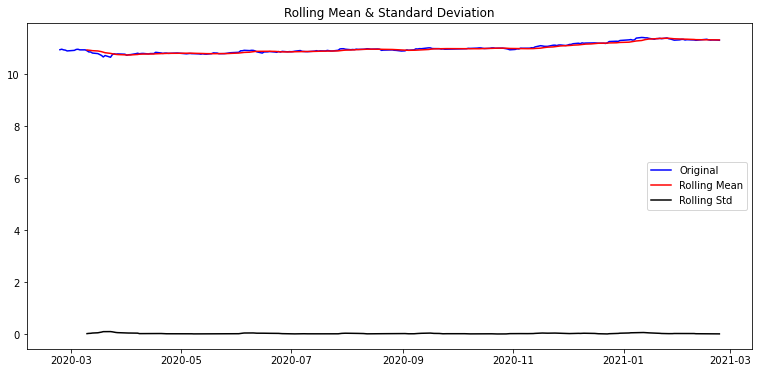

ts_log : 
Results of Dickey-Fuller Test:
Test Statistic                  -0.120486
p-value                          0.947359
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


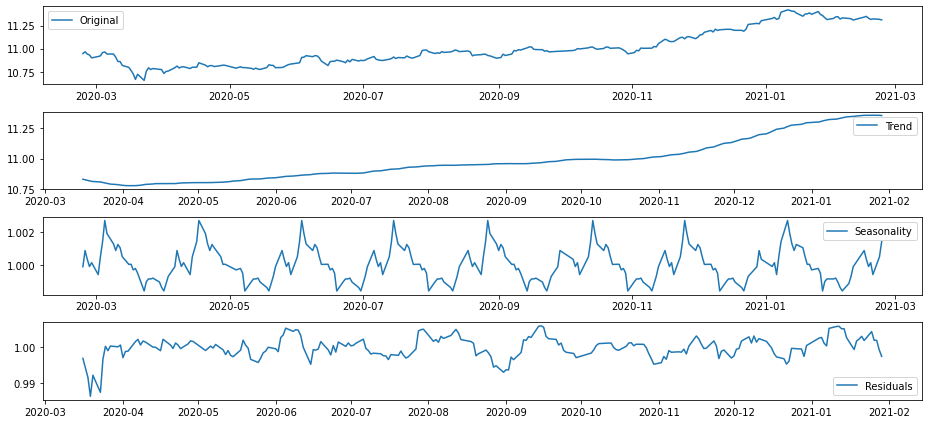

In [29]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
print("ts_log : " )
augmented_dickey_fuller_test(ts_log)
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


### Residual 안정성 확인

In [30]:
# Residual 안정성 확인
residual.dropna(inplace=True)
print("residual : ")
augmented_dickey_fuller_test(residual)

residual : 
Results of Dickey-Fuller Test:
Test Statistic                -5.900911e+00
p-value                        2.779531e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


### 학습, 테스트 데이터셋 생성
---

- 학습, 테스트 데이터셋 분리

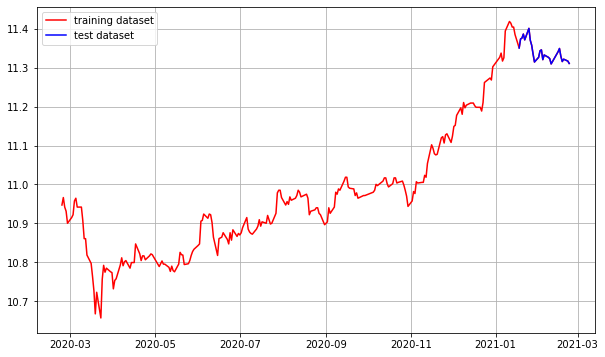

In [31]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

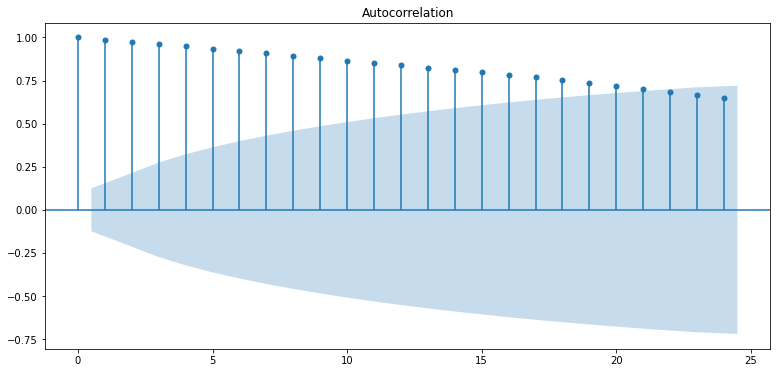

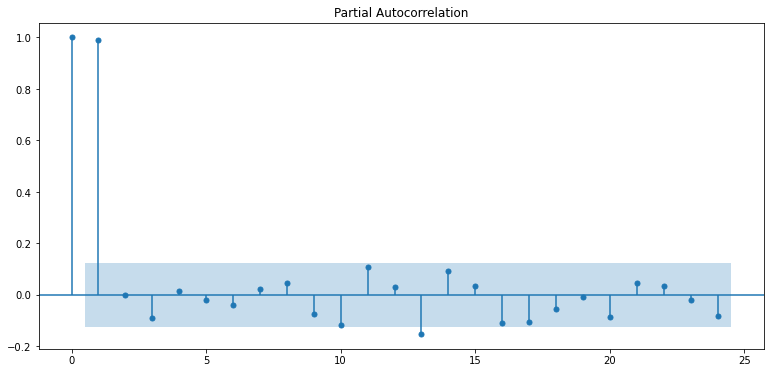

In [32]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


**PACF** 그래프를 볼 때 **p=1**이 적합한 것 같습니다. **p**가 2 이상인 구간에서 **PACF**는 거의 0에 가까워지고 있기 때문입니다. **PACF**가 0이라는 의미는 현재 데이터와 **p** 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.

**ACF**는 점차적으로 감소하고 있어서 **AR(1)** 모델에 유사한 형태를 보이고 있습니다. **q**에 대해서는 적합한 값이 없어 보입니다.**MA**를 고려할 필요가 없다면 **q=0**으로 둘 수 있습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.603651e+01
p-value                        5.977986e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


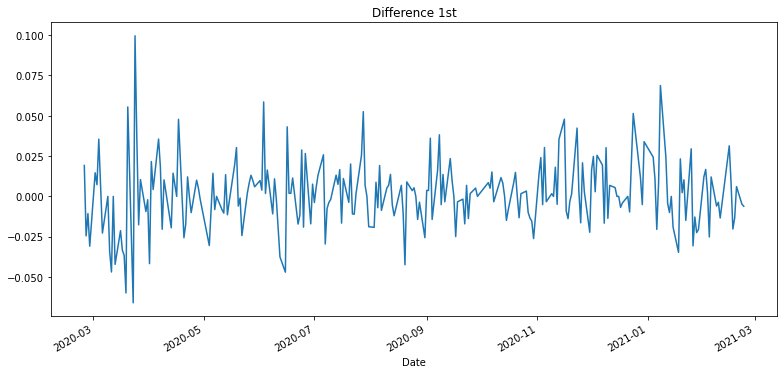

In [33]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.239657e+00
p-value                        1.898964e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


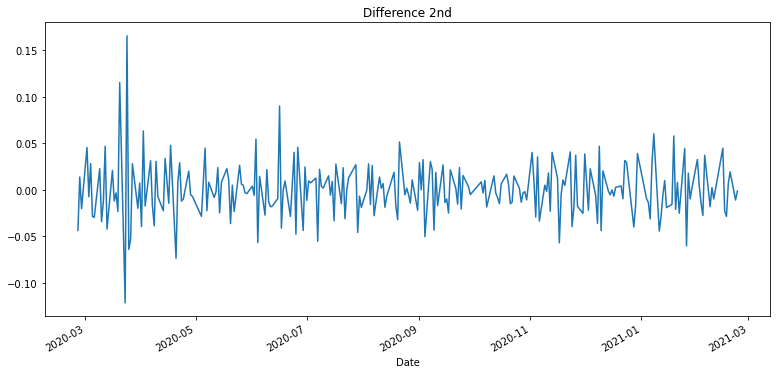

In [34]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분으로도 충분한것 같네요.


##  ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [35]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Mon, 01 Mar 2021   AIC                          -1069.052
Time:                        01:36:33   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

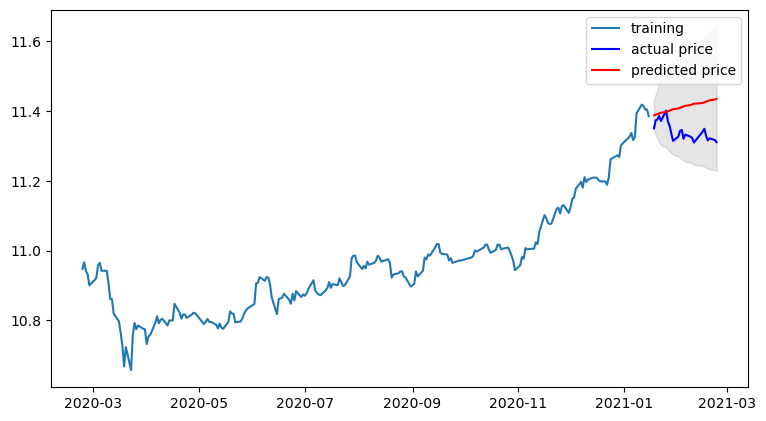

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
# 메소드를 이용해 테스트 데이터 구간의 데이터를 예측합니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드


# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


최종적인 모델의 오차율을 계산하려면, 그동안 로그 변환된 시계열을 사용해 왔던 것을 모두 지수 변환하여 원본의 스케일로 계산해야 합니다.   
**np.exp()**를 통해 전부 원본 스케일로 돌린 후 **`MSE`**, **`MAE`**, **`RMSE`**, **`MAPE`**를 계산해 보았습니다.

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)


rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46645332.34902158
MAE:  6052.034938311396
RMSE:  6829.738819971199
MAPE: 7.27%


삼성의 경우 MAPE가 약 7%의 정확도로 예측이 되었습니다. 

---

## 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기  
   **테슬라, Naver**

---

### 테슬라
주식 시장 정보를 예측하겠습니다.  
삼성과 마찬가지로 종가(Close)를 기준으로 예측해보겠습니다.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 시계열 데이터 준비

data_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(data_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-02-24    166.757996
2020-02-25    159.981995
2020-02-26    155.759995
2020-02-27    135.800003
2020-02-28    133.598007
Name: Close, dtype: float64

 matplotlib.pylab의 rcParams를 통해 안정성(Stationarity) 여부 확인

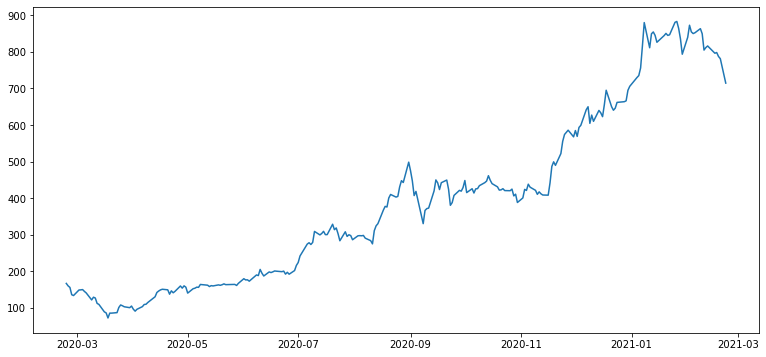

In [43]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다.
plt.plot(ts)

데이터 가공을 진행해 봅시다.

## 전처리 수행
---
- 결측치 처리
- 로그 변환

Series([], Name: Close, dtype: float64)


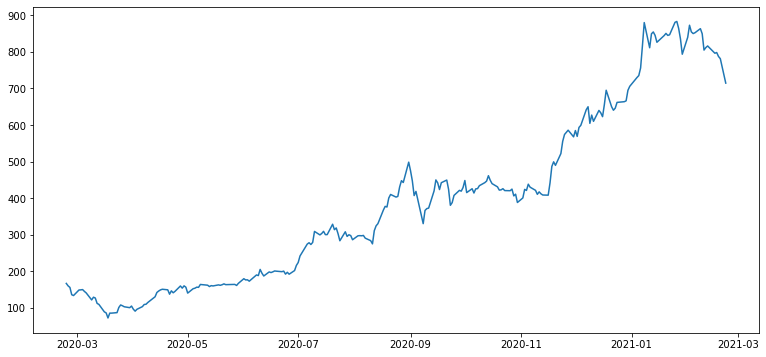

In [44]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 

ts = ts.interpolate(method='time')

print(ts[ts.isna()]) # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

plt.plot(ts)

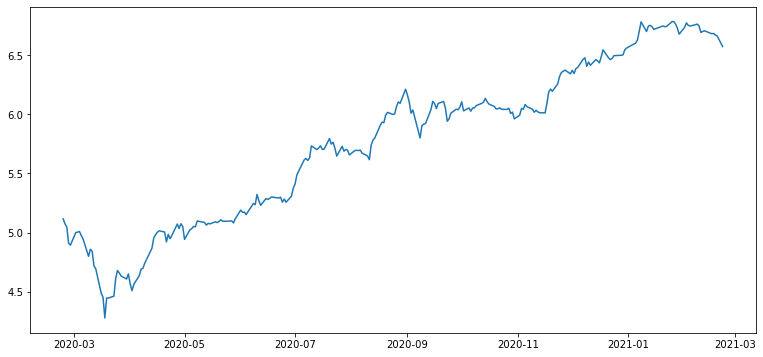

In [45]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### 정성적 그래프 분석 ( plot_rolling_statistics )
- 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다. 

In [46]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

### 정량적 Augmented Dicky-Fuller Test  (augmented_dickey_fuller_test)
-  시계열 데이터의 안정성을 테스트하는 통계적 방법인 Augmented dickey fuller test 함수입니다. 

In [47]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

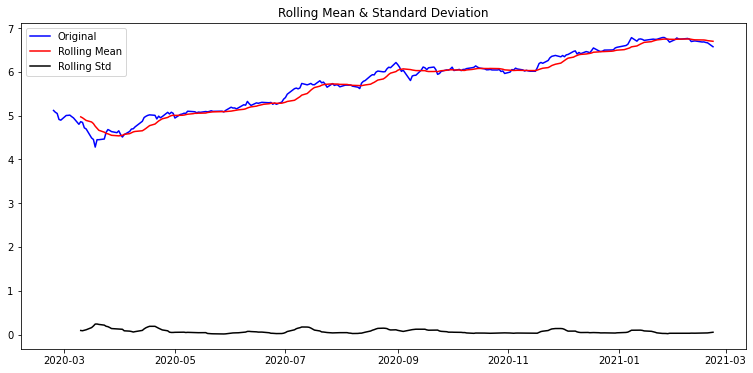

ts_log : 
Results of Dickey-Fuller Test:
Test Statistic                  -0.467626
p-value                          0.898181
#Lags Used                       6.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [49]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
print("ts_log : " )
augmented_dickey_fuller_test(ts_log)

### 시계열 분해 (Time Series Decomposition)
**statsmodels** 라이브러리 안에는 **seasonal_decompose** 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 이 기능을 활용해 안정적인 시계열을 분리해낼 수 있게됩니다.

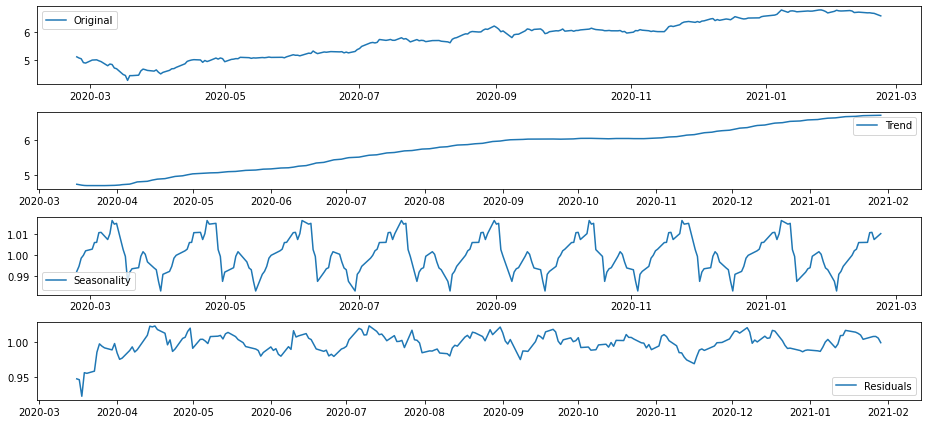

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [50]:
# Residual 안정성 확인
residual.dropna(inplace=True)
print("residual : ")
augmented_dickey_fuller_test(residual)

residual : 
Results of Dickey-Fuller Test:
Test Statistic                -6.218086e+00
p-value                        5.305103e-08
#Lags Used                     3.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


**p-value**가 **5.305103e-08**으로 안정적이네요.

### 학습, 테스트 데이터셋 생성
---

- 학습, 테스트 데이터셋 분리

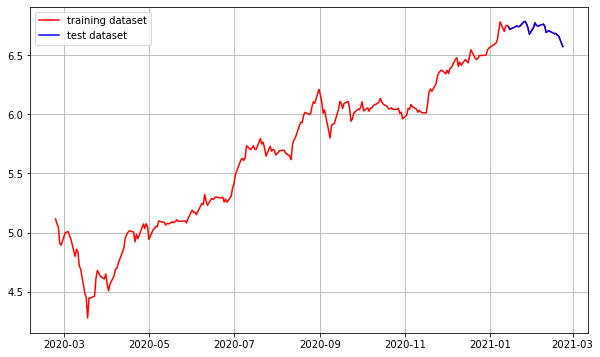

In [51]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

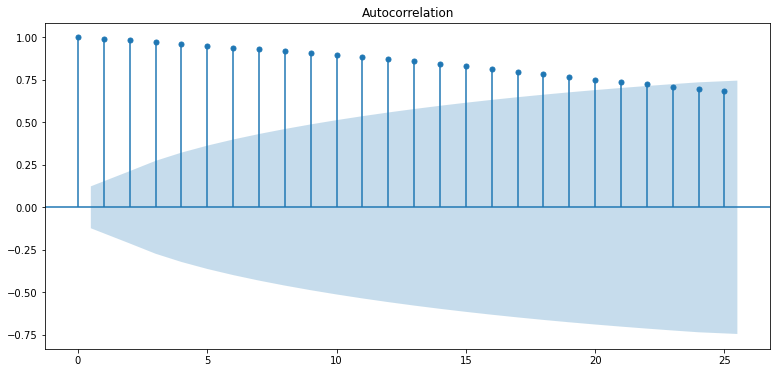

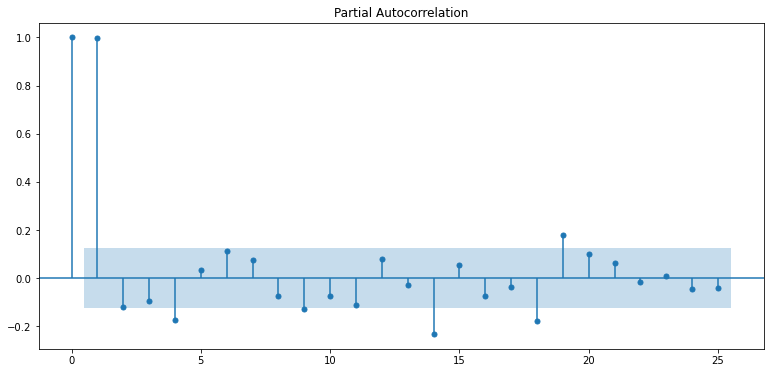

In [52]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


**PACF** 그래프를 볼 때 **p=1**이 적합한 것 같습니다. **p**가 2 이상인 구간에서 **PACF**는 거의 0에 가까워지고 있기 때문입니다.  
**ACF**는 점차적으로 감소하고 있어서 **AR(1)** 모델에 유사한 형태를 보이고 있습니다. **q**에 대해서는 적합한 값이 없어 보입니다.**MA**를 고려할 필요가 없다면 **q=0**으로 둘 수 있습니다.

- p를 1로 두고 q를 0으로 두겠습니다. 


```
             AR(P)                    MA(q)
ACF      점차적으로 감소             시차 q 이후에 0
PACF     시차 p 이후에 0             점차적으로 감소
```

**d**차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 봅시다.

Results of Dickey-Fuller Test:
Test Statistic                -6.931860e+00
p-value                        1.078994e-09
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


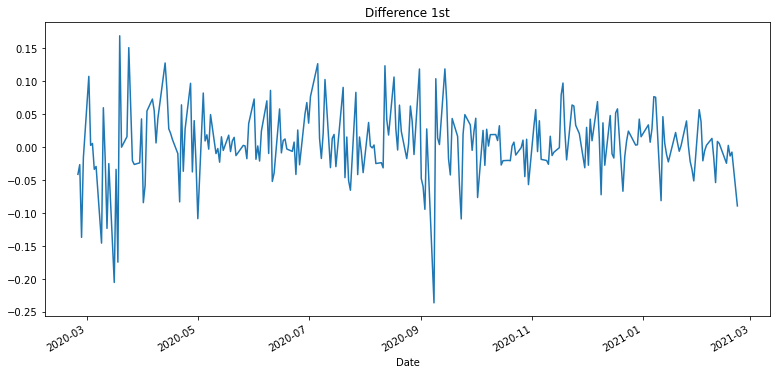

In [53]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.723710e+00
p-value                        3.332121e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


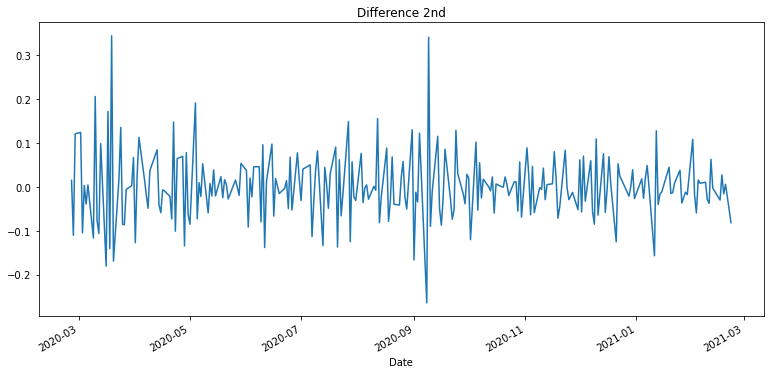

In [54]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분을 구했을때 보다 2차 차분을 구했을때가 더 안정한 상태를 보이므로,  
**d=2**로 차분을 정하고 진행하겠습니다.

##  ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [57]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 291.268
Method:                       css-mle   S.D. of innovations              0.066
Date:                Tue, 23 Feb 2021   AIC                           -576.535
Time:                        15:28:11   BIC                           -566.300
Sample:                             2   HQIC                          -572.404
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.003      0.089      0.929      -0.005       0.006
ar.L1.D2.Close    -0.5503      0.056     -9.915      0.000      -0.659      -0.442
                                    

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

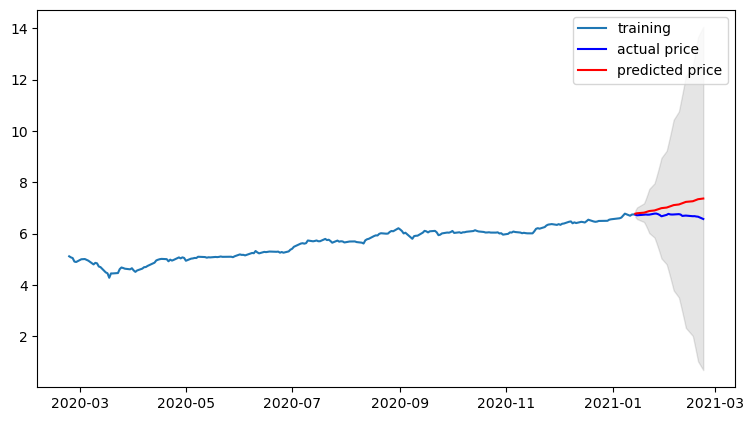

In [59]:
# Forecast : 결과가 fc에 담깁니다. 
# 메소드를 이용해 테스트 데이터 구간의 데이터를 예측합니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드


# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


**np.exp()**를 통해 전부 원본 스케일로 돌린 후 **MSE**, **MAE**, **RMSE**, **MAPE**를 계산해 보았습니다.

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)


rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  181193.31481300868
MAE:  352.2773219701103
RMSE:  425.6680805663125
MAPE: 43.52%


테슬라 주가의 결과가 왜 이런지 찾아보니 최근에 이슈로 주가가 하락세를 가하고 있네요.

---

#### 모수를 변경하며 MAPE를 10% 이하로 낮춰봅시다.

p=1, d=2, q=0의 모수를  p=1, d=1, q=12로 바꿔봅시다.
- 최근 주식 정보 자체가 평소보다 안정성이 떨어지므로 **d=1**을 사용해서 변동성을 주고 q=12를 주어서 더 많은 MA를 고려해 봅시다.   

In [83]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 12))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                ARIMA(1, 1, 12)   Log Likelihood                 337.673
Method:                       css-mle   S.D. of innovations              0.054
Date:                Tue, 23 Feb 2021   AIC                           -645.346
Time:                        15:41:13   BIC                           -594.104
Sample:                             1   HQIC                          -624.664
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0083      0.001      8.270      0.000       0.006       0.010
ar.L1.D.Close      0.9338      0.045     20.557      0.000       0.845       1.023
ma.L1.D.Close     -0.9890      0.079

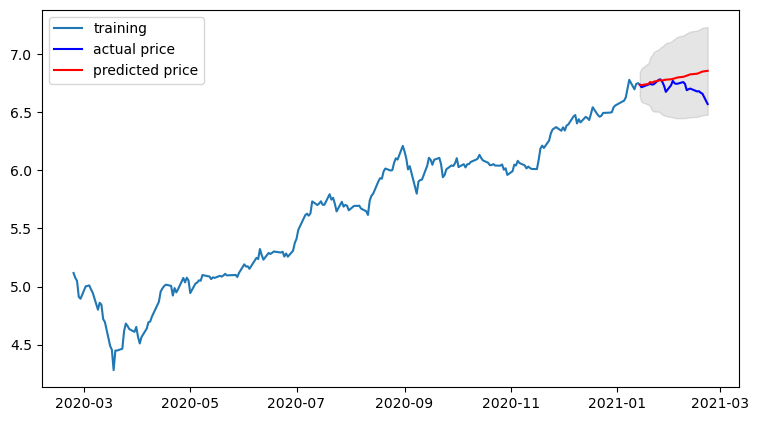

In [80]:
# Forecast : 결과가 fc에 담깁니다. 
# 메소드를 이용해 테스트 데이터 구간의 데이터를 예측합니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드


# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


**np.exp()**를 통해 전부 원본 스케일로 돌린 후 **MSE**, **MAE**, **RMSE**, **MAPE**를 계산해 보았습니다.

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)


rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7640.932506415555
MAE:  63.1658847112945
RMSE:  87.41242764284466
MAPE: 7.93%


7.93으로 MAPE를 10% 이하로 낮추기는 했지만, 주식 가격의 감소 부분은 시장 외 부분에서의 영향 때문에 일어난 감소여서 ARIMA모델로 정확한 예측은 하지 못하는것 같습니다. 

<br> 

---

<br>

##  Naver
- Naver의 주식 정보를 예측하겠습니다. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 시계열 데이터 준비

data_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/Naver.csv'
df = pd.read_csv(data_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-03-02    175000.0
2020-03-03    175000.0
2020-03-04    178500.0
2020-03-05    181000.0
2020-03-06    179500.0
Name: Close, dtype: float64

 matplotlib.pylab의 rcParams를 통해 안정성(Stationarity) 여부 확인

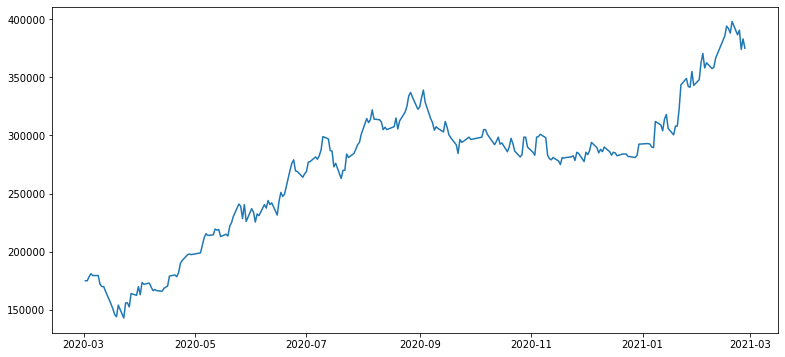

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다.
plt.plot(ts)

데이터 가공을 진행해 봅시다.

## 전처리 수행
---
- 결측치 처리
- 로그 변환

Series([], Name: Close, dtype: float64)


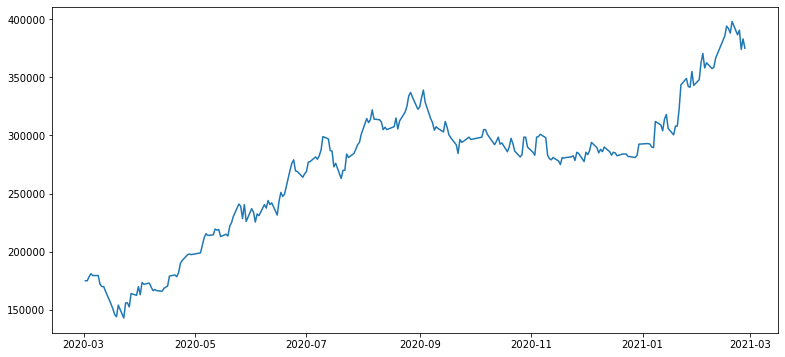

In [3]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 

ts = ts.interpolate(method='time')

print(ts[ts.isna()]) # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

plt.plot(ts)

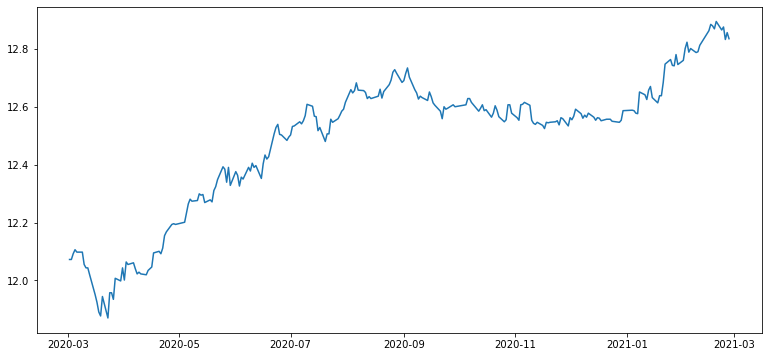

In [4]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### 정성적 그래프 분석 ( plot_rolling_statistics )
- 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다. 

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

### 정량적 Augmented Dicky-Fuller Test  (augmented_dickey_fuller_test)
-  시계열 데이터의 안정성을 테스트하는 통계적 방법인 Augmented dickey fuller test 함수입니다. 

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

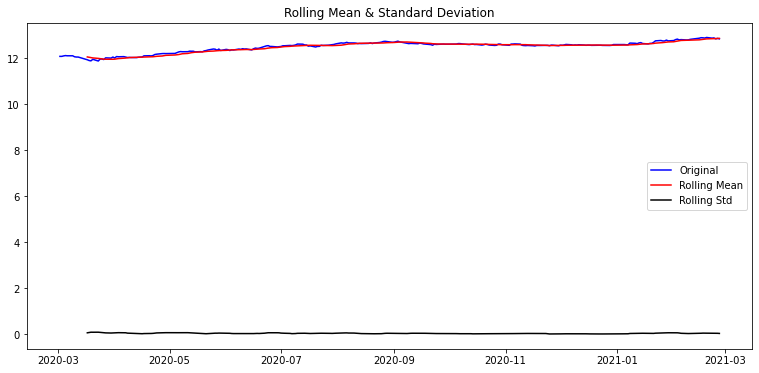

ts_log : 
Results of Dickey-Fuller Test:
Test Statistic                  -1.034164
p-value                          0.740601
#Lags Used                       1.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
print("ts_log : " )
augmented_dickey_fuller_test(ts_log)

### 시계열 분해 (Time Series Decomposition)
**statsmodels** 라이브러리 안에는 **seasonal_decompose** 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 이 기능을 활용해 안정적인 시계열을 분리해낼 수 있게됩니다.

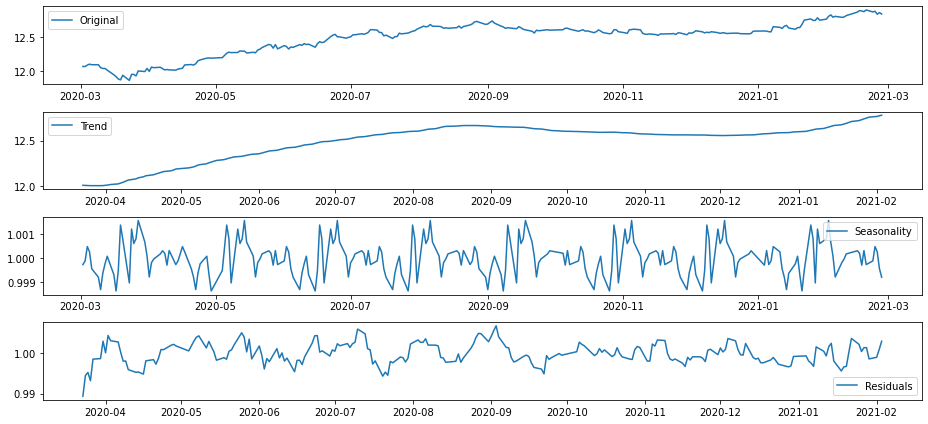

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [9]:
# Residual 안정성 확인
residual.dropna(inplace=True)
print("residual : ")
augmented_dickey_fuller_test(residual)

residual : 
Results of Dickey-Fuller Test:
Test Statistic                -6.645998e+00
p-value                        5.263937e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


**p-value**가 **5.263937e-09**으로 안정적이네요.

### 학습, 테스트 데이터셋 생성
---

- 학습, 테스트 데이터셋 분리

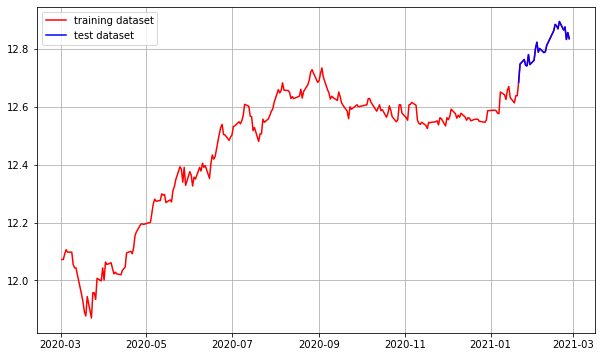

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

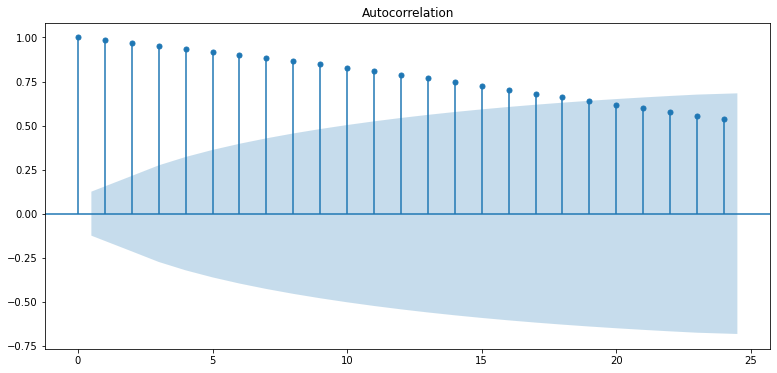

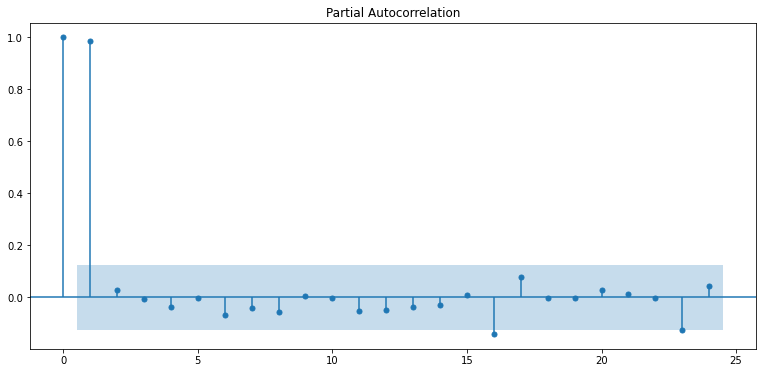

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Naver도 삼성과 비슷한 그래프를 그리고 있습니다.

**PACF** 그래프를 볼 때 **p=1**이 적합한 것 같습니다. **p**가 2 이상인 구간에서 **PACF**는 거의 0에 가까워지고 있기 때문입니다.  
**ACF**는 점차적으로 감소하고 있어서 **AR(1)** 모델에 유사한 형태를 보이고 있습니다. **q**에 대해서는 적합한 값이 없어 보입니다.**MA**를 고려할 필요가 없다면 **q=0**으로 둘 수 있습니다.

- p를 1로 두고 q를 0으로 두겠습니다. 


```
             AR(P)                    MA(q)
ACF      점차적으로 감소             시차 q 이후에 0
PACF     시차 p 이후에 0             점차적으로 감소
```

**d**차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 봅시다.

Results of Dickey-Fuller Test:
Test Statistic                -1.781334e+01
p-value                        3.182620e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


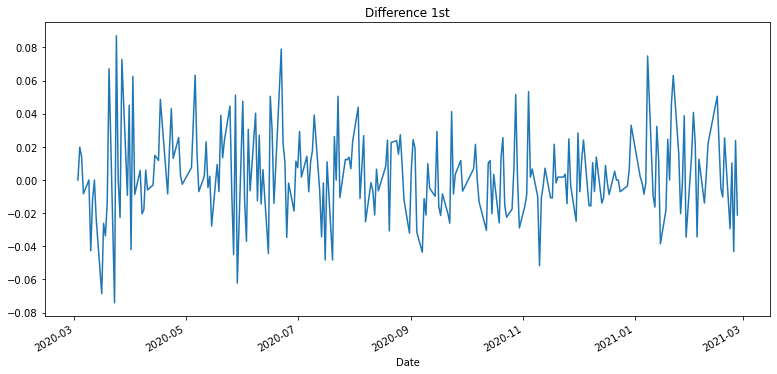

In [12]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.468975e+00
p-value                        5.114471e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


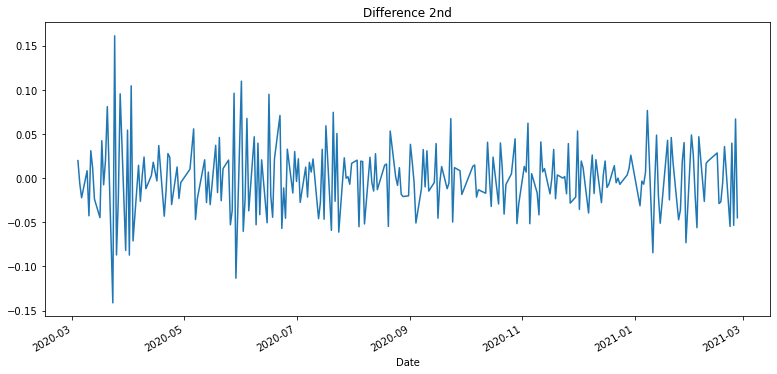

In [13]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분을 구했을때 보다 2차 차분을 구했을때가 더 안정한 상태를 보이므로,  
**d=2**로 차분을 정하고 진행하겠습니다.

##  ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  219
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 445.537
Method:                       css-mle   S.D. of innovations              0.032
Date:                Mon, 01 Mar 2021   AIC                           -885.075
Time:                        01:30:54   BIC                           -874.908
Sample:                             2   HQIC                          -880.968
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.344e-06      0.001      0.006      0.995      -0.003       0.003
ar.L1.D2.Close    -0.6018      0.054    -11.208      0.000      -0.707      -0.497
                                    

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

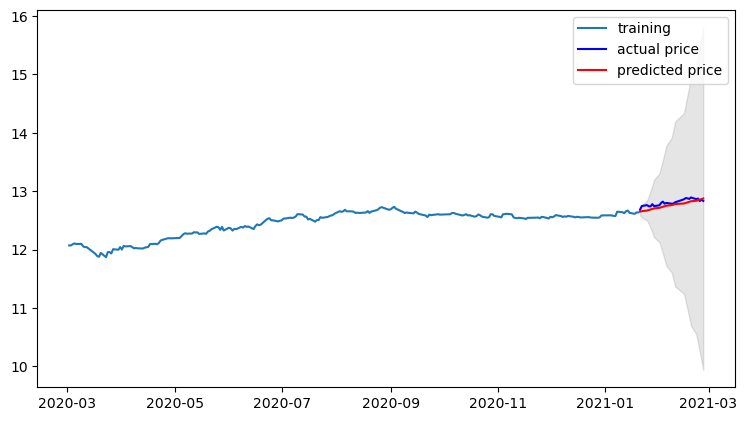

In [15]:
# Forecast : 결과가 fc에 담깁니다. 
# 메소드를 이용해 테스트 데이터 구간의 데이터를 예측합니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드


# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


**np.exp()**를 통해 전부 원본 스케일로 돌린 후 **MSE**, **MAE**, **RMSE**, **MAPE**를 계산해 보았습니다.

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)


rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  411249225.0707329
MAE:  18415.104896831323
RMSE:  20279.280684253397
MAPE: 5.03%


MAPE가 약 5% 정도로 ARIMA 모델의 예측이 잘 되었습니다.

삼성, 테슬라가 약 7%로 흡사하고, NAVER가 5%로 가장 잘 예측한 것을 알 수 있습니다. 

---

## 회고
- 삼성, 테슬라, 네이버 모두 MAPE가 10% 미만의 정확도로 예측하는데 성공했습니다.  
그리고 **%** 수치로만 보면 3개의 종목 모두 비슷한 **MAPE**를 가지고 있지만,  좀 더 살펴보면 삼성, 테슬라의 경우 그래프를 봤을때 모델이 아래로 내려 가는 그래프를 가지지만, **Naver**의 경우 예측된 미래와 실제 데이터가 상당히 유사함을 알 수 있습니다.  


- 위의 내용을 봤을때 ARIMA모델은 외부 시장 사항과 같은 급격한 변화에 대해 제대로 대응을 못한다라는 것을 알 수 있습니다.  물론 단순히 이전 시간대에 데이터만으로 미래 주식 데이터를 정확하게 예측하는것은 다소 어려움이 있는것 같습니다.다.  
따라서, 실제로 **ARIMA** 모델을 가지고 주식을 에측하려면 다른 외부 시장 사항을 직접 파악해서 모델에 영향을 주거나, 아니면 다른 모델을 사용하여 얻은 정보들과 **ARIMA**의 결과를 가지고 주식이 오를지 내릴지 결정해야할 것 같습니다. 


- 그렇지만, 실제로 주식을 예측하는 모델을 만들려면 **ARIMA** 모델 말고 다른 방법으로 하는것이 더 나은것 같습니다.


- 이렇게 ARIMA를 사용해 주식을 예측해보니 주식 예측이 얼마나 어려운지 알게 된것 같습니다. 그렇지만, 시장외 사건이 없는 경우에는 확률이 높지만 그게 아니면 확률이 낮아지니, 모델을 만들어서 주식으로 돈벌려면 아직 더 많은 공부를 하고 더 많은 시간을 들여서 모델을 만들어야지 믿고 실제로 주식을 사거나 팔 수 있겠네요

